In [104]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
import datetime as dt


def read_in_data():
    """
    Reads in our collected BTC csv into a pandas data frame and removes all other columns other than the close price
    
    :param - 
    :returns - Pandas data frame containing the close price indexed by time
    """
    data_frame = pd.DataFrame()
    file = "BTCPRICE.csv"
    data_frame = pd.read_csv(file, names=["time", "open", "high", "low", "close", "volume"])
    data_frame.set_index("time", inplace = True)
    data_frame = data_frame[["close"]]     
    return data_frame

In [105]:
def create_lag(df, look_ahead):
    """
    takes in our data frame and look ahead value and creates and new column in our data frame called (look_ahead)+_days_forecast 
    this column contains values that are lagged by the look_ahead amount.
    
    :param - df - data frame, look_ahead value
    :returns - close_list of the original values, fore_cast_close_list of lagged values
    """
    df[str(look_ahead)+'_days_forecast'] = df[['close']].shift(-look_ahead)
    df.dropna(inplace=True) 
    
    close_list = df[["close"]].values
    forecast_close_list = df[[str(look_ahead)+'_days_forecast']].values
    
    return close_list, forecast_close_list

In [106]:
def normalize_data(scaler, close_list, forecast_close_list):
    """
    this section takes in our two new value lists and scales them using a minmaxscaler within the range 0,1
    we then seperate our data into training and testing sets to be used to train and evaluate our model
    
    :param - scaler, close_list, forecast_close_list
    :returns - X_test, X_train, y_test, y_train
    """
    close_list = scaler.fit_transform(close_list)
    forecast_close_list = scaler.fit_transform(forecast_close_list)


    X_test = close_list[-int(len(close_list)*0.2):]
    X_train = close_list[:int(len(close_list)*0.8)]

    y_test = forecast_close_list[-int(len(forecast_close_list)*0.2):]
    y_train = forecast_close_list[:int(len(close_list)*0.8)]
    
    return X_test, X_train, y_test, y_train

In [107]:
def run_grid_search(X_train, y_train):
    """
    this method performs a grid search to find the optimal parameters using our X_train and y_train values
    it then fits our optimal model to our training data
    
    :param - X_train, y_train
    :returns - X_test, X_train, y_test, y_train
    """
    grid_parameters = {'C': [0.1,1,10,100,1000, 10000], 'gamma':[1,0.1,0.01,0.001, 0.0001, 0.00001], 'kernel':['rbf']}
    
    model = GridSearchCV(SVR(), grid_parameters, refit=True, verbose = 2)
    model.fit(X_train, y_train.ravel())
    
    return model

In [108]:
def run_svr(model, scaler, close_list, X_train, X_test):
    """
    here we use our optimal model to make predicitons on our X_train and X_test set to evaluate how accuratly the model performed
    we then plot our predicted values to the real movement of the BTC price
    
    :param - scaler, close_list, forecast_close_list
    :returns - X_test, X_train, y_test, y_train
    """
    train_prediction = model.predict(X_train)
    test_prediction = model.predict(X_test)
    
    train_prediction = scaler.inverse_transform(train_prediction.reshape(-1,1))
    test_prediction = scaler.inverse_transform(test_prediction.reshape(-1,1))  
  
    real_btc_price = close_list[:-1]    
    forecast_movement = np.concatenate((train_prediction,test_prediction))
   
    
    plt.figure(figsize=(16,8))    
    plt.plot(real_btc_price, color = 'green',label='Real BTC Price')
    plt.plot(forecast_movement, color = 'purple', label='Predicted BTC Price')
    plt.xlabel('Trades')
    plt.ylabel('BTC PRICE')
    plt.legend(loc='upper left')
    plt.show()
    

In [109]:
#Here we initalize our Look_ahead lag value and scaler
look_ahead = 15
scaler = MinMaxScaler(feature_range=(0, 1))

df = read_in_data()
close_list, forecast_close_list = create_lag(df, look_ahead)
X_test, X_train, y_test, y_train = normalize_data(scaler, close_list, forecast_close_list)
model = run_grid_search(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   0.2s
[CV] END ......................C=0.1, gamma=0.0

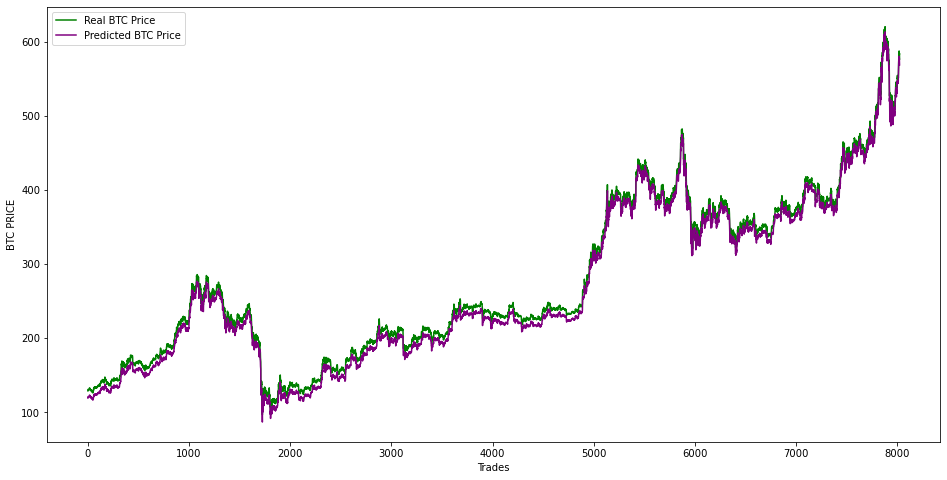

In [110]:
run_svr(model, scaler, close_list, X_train, X_test)